In [1]:
import tensorflow as tf
import cv2
import numpy as np
import seaborn as sns
import pickle
from training_utils import DeformableConv2D, DroppingLayer, ResizingLayer, ChannelNormalization, patches_to_images
tf.experimental.numpy.experimental_enable_numpy_behavior()

[[2.1445069313049316, 0.0, 0.0, 0.0], [0.0, 2.144399642944336, 0.010004834271967411, 0.009999833069741726], [0.0, 0.021444711834192276, -1.0004500150680542, -0.9999499917030334], [0.0, 0.0, 4.982495307922363, 5.0]]
proof of Assumption :  we can calculate the $ T $ only by determining the new location on features points in screent at $t=t_n$. Following is the proof of assumption


In [18]:
image_id = 4817

In [19]:
img = cv2.imread(f"Dataset/synthetic_shapes/images/output_{image_id}.jpeg")
cv2.imshow("img", img)
cv2.waitKey(4)

-1

In [20]:
with tf.keras.utils.custom_object_scope({'DeformableConv2D': DeformableConv2D,
                                      'DroppingLayer': DroppingLayer,
                                      'ResizingLayer': ResizingLayer,
                                      'ChannelNormalization': ChannelNormalization}):
        model = tf.keras.models.load_model("model.h5")

In [21]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow("img", img)
cv2.waitKey(4)

-1

In [22]:
img = np.expand_dims(img, axis=0)

In [23]:
output = model(img)

In [24]:
k = patches_to_images(output[0][:,:,:,:-1])

<Axes: >

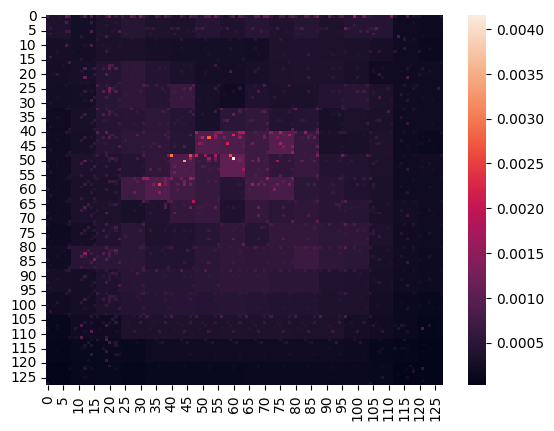

In [25]:
sns.heatmap(k[0])

In [26]:
output[0].shape

TensorShape([1, 16, 16, 65])

<Axes: >

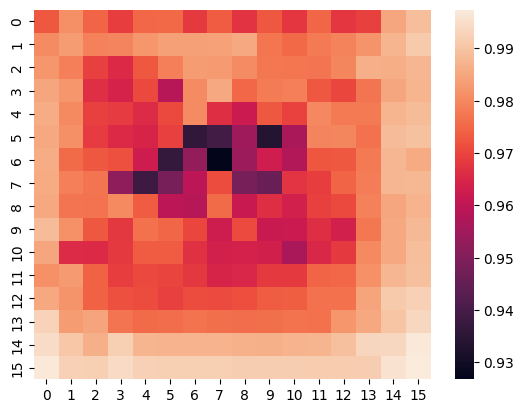

In [27]:
sns.heatmap(output[0][0,:,:,-1])

In [28]:
with open(f"Dataset/synthetic_shapes/keypoints/output_{image_id}.pkl", 'rb') as f:
        kps = np.array(pickle.load(f))
        print(kps)

[[ 22  73]
 [ 61  20]
 [102  47]]


In [29]:
def images_to_patches(images):
    n, h, w = images.shape
    patches = images.reshape(n, h//8, 8, w//8, 8).transpose(0, 1, 3, 2, 4).reshape(n, h//8, w//8, 64)
    return patches

In [30]:
def create_65_layers(map):
    map = images_to_patches(map)
    # ones_mask = tf.equal(map, 1)
    
    # # Cumulative sum along the last dimension to identify the first 1
    # cumsum_ones = tf.cumsum(tf.cast(ones_mask, tf.int32), axis=-1)
    
    # # Create a mask to keep only the first 1 in each last dimension slice
    # first_one_mask = tf.equal(cumsum_ones, 1)
    
    # # Apply the mask to the original array to keep only the first 1s
    # processed_arr = tf.where(first_one_mask, tf.ones_like(map), tf.zeros_like(map))
    
    layer_65 = np.ones((*map.shape[:-1], 1), dtype=int)
    all_zeros = np.all(map == 0, axis= -1)
    layer_65[:,:,:,0] = all_zeros
    map = np.concatenate([map, layer_65], axis = -1)
    return map

In [31]:
gt = np.zeros((1, 128, 128))
if (kps.shape[0] > 0):
    if (kps.shape[1] == 2):
        for kp in kps:
            gt[0][kp[1],kp[0]] = 1
            
gt = create_65_layers(gt)


<Axes: >

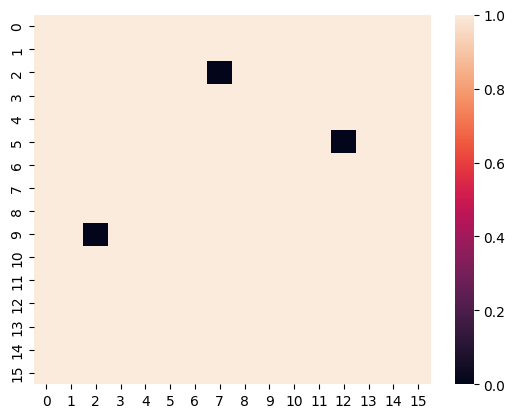

In [32]:
sns.heatmap(gt[0,:,:,-1])